In [ ]:
# Date: 2025-08-11    Capstone Project — Partial Code -- Model 1 --  CNN    Authors: Joseph Friedel, Bilal Najar, Daniel Shifrin

In [ ]:
# Assignment 7, CNN Model with Optimization

In [55]:
import os
import shutil
from PIL import Image, ImageEnhance, ImageOps
import random
import traceback
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras import layers, models, optimizers, losses

In [2]:
# Input and output directories
input_dir = r'C:\Users\josep\RF Signals'
output_dir = r'C:\Users\josep\RF Signals Balanced'
target_count = 2000
resize_dim = (224, 224)

In [3]:
# Logging
failed_images = []

In [4]:
# === Data Augmentation Function ===
def augment_image(img):
    transformations = [
        lambda x: x.rotate(random.uniform(-15, 15)),
        lambda x: ImageOps.mirror(x),
        # lambda x: ImageOps.flip(x),   # Do not Flip images
        lambda x: ImageEnhance.Brightness(x).enhance(random.uniform(0.7, 1.3)),
        lambda x: ImageEnhance.Contrast(x).enhance(random.uniform(0.7, 1.3)),
    ]
    return random.choice(transformations)(img)

In [5]:
# === Histogram Equalization ===
def equalize_histogram(img):
    if img.mode != "RGB":
        img = img.convert("RGB")
    r, g, b = img.split()
    return Image.merge("RGB", (ImageOps.equalize(r), ImageOps.equalize(g), ImageOps.equalize(b)))

In [6]:
# === Process Each Class Folder ===
os.makedirs(output_dir, exist_ok=True)

In [7]:
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f'🔍 Processing class: {class_name}')
    orig_images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(orig_images) == 0:
        print(f'⚠️ Skipping {class_name} — no images found.')
        continue

    new_class_path = os.path.join(output_dir, class_name)
    os.makedirs(new_class_path, exist_ok=True)
    # Copy and standardize up to 2000 original images
    copy_count = min(target_count, len(orig_images))
    for i in range(copy_count):
        try:
            orig_name = orig_images[i]
            src = os.path.join(class_path, orig_name)
            with Image.open(src) as img:
                img = img.convert("RGB")
                img = img.resize(resize_dim)
                img = equalize_histogram(img)
                base_name = os.path.splitext(orig_name)[0]
                dst = os.path.join(new_class_path, f"{base_name}.jpg")
                img.save(dst, format='JPEG')
        except Exception as e:
            print(f"❌ Failed to process {orig_name} in {class_name}")
            failed_images.append((class_name, orig_name, str(e)))
            continue    
    # Augment if less than 2000 images
    current_count = len(os.listdir(new_class_path))
    needed = target_count - current_count
    if needed > 0:
        print(f'➕ Augmenting {needed} images for {class_name}')
        for i in range(needed):
            try:
                orig_name = orig_images[i % len(orig_images)]
                orig_path = os.path.join(class_path, orig_name)
                with Image.open(orig_path) as img:
                    img = img.convert("RGB")
                    img = augment_image(img)
                    img = img.resize(resize_dim)
                    img = equalize_histogram(img)
                    aug_name = f"aug_{i}_{os.path.splitext(orig_name)[0]}.jpg"
                    aug_path = os.path.join(new_class_path, aug_name)
                    img.save(aug_path, format='JPEG')
            except Exception as e:
                print(f"❌ Failed to augment {orig_name} in {class_name}")
                failed_images.append((class_name, orig_name, str(e)))
                continue

    final_count = len(os.listdir(new_class_path))
    print(f'✅ {class_name}: {final_count} images total.')

# === Log Any Failures ===
if failed_images:
    log_path = os.path.join(output_dir, 'failed_images_log.txt')
    with open(log_path, 'w') as f:
        for entry in failed_images:
            f.write(f"Class: {entry[0]} | File: {entry[1]} | Error: {entry[2]}\n")
    print(f"\n⚠️ Logged {len(failed_images)} failed image(s) to {log_path}")

print("\n🎉 Dataset balancing to 2000 images per class complete.")

🔍 Processing class: 16QAM
✅ 16QAM: 2000 images total.
🔍 Processing class: 2ASK
✅ 2ASK: 2000 images total.
🔍 Processing class: 32QAM
✅ 32QAM: 2000 images total.
🔍 Processing class: 4FSK
✅ 4FSK: 2000 images total.
🔍 Processing class: 8PSK
✅ 8PSK: 2000 images total.
🔍 Processing class: ads-b
➕ Augmenting 602 images for ads-b
✅ ads-b: 1398 images total.
🔍 Processing class: airband
✅ airband: 2000 images total.
🔍 Processing class: ais
➕ Augmenting 34 images for ais
✅ ais: 1966 images total.
🔍 Processing class: am
✅ am: 2000 images total.
🔍 Processing class: atsc
✅ atsc: 2000 images total.
🔍 Processing class: automatic-picture-transmission
➕ Augmenting 685 images for automatic-picture-transmission
✅ automatic-picture-transmission: 1315 images total.
🔍 Processing class: bluetooth
➕ Augmenting 790 images for bluetooth
✅ bluetooth: 1210 images total.
🔍 Processing class: cellular
➕ Augmenting 597 images for cellular
✅ cellular: 1403 images total.
🔍 Processing class: digital-audio-broadcasting
➕ 

In [8]:
balanced_dir = r'C:\Users\josep\RF Signals Balanced'

# Supported image formats
extensions = ('.jpg', '.jpeg', '.png')

print(f"\n📊 Image counts in each class under: {balanced_dir}\n")

for class_name in sorted(os.listdir(balanced_dir)):
    class_path = os.path.join(balanced_dir, class_name)
    if os.path.isdir(class_path):
        files = [f for f in os.listdir(class_path) if f.lower().endswith(extensions)]
        count = len(files)
        print(f"{class_name:35} {count:5} images")


📊 Image counts in each class under: C:\Users\josep\RF Signals Balanced

16QAM                                2000 images
2ASK                                 2000 images
32QAM                                2000 images
4FSK                                 2000 images
8PSK                                 2000 images
RS41-Radiosonde                      1276 images
Radioteletype                        1027 images
ads-b                                1398 images
airband                              2000 images
ais                                  1966 images
am                                   2000 images
atsc                                 2000 images
automatic-picture-transmission       1315 images
bluetooth                            1210 images
cellular                             1403 images
digital-audio-broadcasting           1066 images
digital-speech-decoder               1050 images
drone-video                          1006 images
fm                                   1737 ima

In [9]:
# Path to the balanced image dataset
balanced_dir = r'C:\Users\josep\RF Signals Balanced'

# Modulation mapping
modulation_map = {
    "16QAM": 1, "2ASK": 2, "32QAM": 3, "4FSK": 4, "8PSK": 5, "RS41-Radiosonde": 6,
    "Radioteletype": 7, "ads-b": 8, "airband": 9, "ais": 10, "am": 11, "atsc": 12,
    "automatic-picture-transmission": 13, "bluetooth": 14, "cellular": 15,
    "digital-audio-broadcasting": 16, "digital-speech-decoder": 17, "drone-video": 18,
    "fm": 19, "hdmi": 20, "lora": 21, "morse": 22, "on-off-keying": 23, "packet": 24,
    "pocsag": 25, "remote-keyless-entry": 26, "sstv": 27, "uav-video": 28,
    "vor": 29, "wifi": 30, "z-wave": 31
}

# Initialize rows for the dataframe
rows = []
line_number = 1

# Walk through each class directory
for class_name, class_number in modulation_map.items():
    class_dir = os.path.join(balanced_dir, class_name)
    if not os.path.isdir(class_dir):
        print(f"⚠️ Skipping missing folder: {class_dir}")
        continue

    for file in sorted(os.listdir(class_dir)):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(class_name, file)  # relative path
            rows.append({
                "Line Number": line_number,
                "Modulation Type": class_number,
                "Image File": file_path
            })
            line_number += 1

# Create the DataFrame
df = pd.DataFrame(rows, columns=["Line Number", "Modulation Type", "Image File"])

# Save to CSV
csv_path = os.path.join(balanced_dir, "modulation_dataset_index.csv")
df.to_csv(csv_path, index=False)

print(f"✅ DataFrame created with {len(df)} entries.")
print(f"📄 CSV saved to: {csv_path}")

✅ DataFrame created with 44304 entries.
📄 CSV saved to: C:\Users\josep\RF Signals Balanced\modulation_dataset_index.csv


In [10]:
csv_path

'C:\\Users\\josep\\RF Signals Balanced\\modulation_dataset_index.csv'

In [11]:
print(df.head())

   Line Number  Modulation Type                                  Image File
0            1                1  16QAM\0e1cfa6e27cf27b164f26b8316e00d96.jpg
1            2                1  16QAM\0e1cfa6e27cf27b164f26b8316e00d96.png
2            3                1  16QAM\27a8846fbce39f300a7e3f80ab0403e4.jpg
3            4                1  16QAM\27a8846fbce39f300a7e3f80ab0403e4.png
4            5                1  16QAM\356c8cb0c6f5f196f348285f398a51d5.jpg


In [12]:
# Remove exact duplicates based on 'Image File'
df_cleaned = df.drop_duplicates(subset=["Image File"]).reset_index(drop=True)

# Show how many were removed
removed = len(df) - len(df_cleaned)
print(f"✅ Removed {removed} duplicate image entries.")
print(f"📊 Cleaned DataFrame now has {len(df_cleaned)} unique images.")

# Show first 5 rows
print(df_cleaned.head())

✅ Removed 0 duplicate image entries.
📊 Cleaned DataFrame now has 44304 unique images.
   Line Number  Modulation Type                                  Image File
0            1                1  16QAM\0e1cfa6e27cf27b164f26b8316e00d96.jpg
1            2                1  16QAM\0e1cfa6e27cf27b164f26b8316e00d96.png
2            3                1  16QAM\27a8846fbce39f300a7e3f80ab0403e4.jpg
3            4                1  16QAM\27a8846fbce39f300a7e3f80ab0403e4.png
4            5                1  16QAM\356c8cb0c6f5f196f348285f398a51d5.jpg


In [13]:
# Add a 'Base Name' column (filename without extension)
df['Base Name'] = df['Image File'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
df['Extension'] = df['Image File'].apply(lambda x: os.path.splitext(x)[1].lower())

# Sort so PNG comes after JPG 
df_sorted = df.sort_values(by=['Base Name', 'Extension'], ascending=[True, False])

# Drop duplicates based on 'Base Name', keeping the .png version
df_deduped = df_sorted.drop_duplicates(subset=['Base Name'], keep='first').reset_index(drop=True)

# Drop helper columns
df_deduped = df_deduped.drop(columns=['Base Name', 'Extension'])

# Reassign new line numbers
df_deduped['Line Number'] = range(1, len(df_deduped) + 1)

# Save to CSV
csv_path = os.path.join(balanced_dir, "modulation_dataset_index_nodupes.csv")
df_deduped.to_csv(csv_path, index=False)

print(f"✅ Removed .jpg duplicates — only .png versions retained when both exist.")
print(f"📊 Final count: {len(df_deduped)} unique image entries.")



✅ Removed .jpg duplicates — only .png versions retained when both exist.
📊 Final count: 34613 unique image entries.


In [14]:
# Group by 'Modulation Type' and count entries
modulation_counts = df_deduped.groupby('Modulation Type')['Image File'].count()

# Display the counts
print(modulation_counts.sort_index())

Modulation Type
1     1000
2     1000
3     1000
4     1000
5     1000
6     1276
7     1027
8     1000
9     1000
10    1000
11    1000
12    1000
13     988
14    1210
15    1403
16    1066
17    1050
18    1006
19    1737
20    1010
21    1596
22    1047
23    1043
24    1299
25    1041
26    1128
27    1099
28    1006
29    1085
30    1293
31    1203
Name: Image File, dtype: int64


In [15]:
# Show first 5 rows
print(df_deduped.head())

   Line Number  Modulation Type                                     Image File
0            1                9   airband\000b948821b3d6f1ff4f1e1c9ff0993f.png
1            2               19        fm\001dfbacbf3bf79fa0342008144101b4.jpg
2            3               15  cellular\001e0e34110b90d464f64be5b31c0f18.jpg
3            4               30      wifi\006dc1c484f02d93ad64a2c77a3a60b7.jpg
4            5                9   airband\0073085f5246828f3b2a515d5882d48d.png


In [16]:
# Map numbers back to names
modulation_name_map = {
    1: "16QAM", 2: "2ASK", 3: "32QAM", 4: "4FSK", 5: "8PSK", 6: "RS41-Radiosonde",
    7: "Radioteletype", 8: "ads-b", 9: "airband", 10: "ais", 11: "am", 12: "atsc",
    13: "automatic-picture-transmission", 14: "bluetooth", 15: "cellular",
    16: "digital-audio-broadcasting", 17: "digital-speech-decoder", 18: "drone-video",
    19: "fm", 20: "hdmi", 21: "lora", 22: "morse", 23: "on-off-keying", 24: "packet",
    25: "pocsag", 26: "remote-keyless-entry", 27: "sstv", 28: "uav-video",
    29: "vor", 30: "wifi", 31: "z-wave"
}

# Convert Series to DataFrame for better formatting
modulation_counts_df = modulation_counts.reset_index()
modulation_counts_df['Modulation Name'] = modulation_counts_df['Modulation Type'].map(modulation_name_map)

# Reorder columns
modulation_counts_df = modulation_counts_df[['Modulation Type', 'Modulation Name', 'Image File']]
modulation_counts_df.columns = ['Modulation Type', 'Modulation Name', 'Image Count']

# Sort and display
print(modulation_counts_df.sort_values(by='Modulation Type'))

    Modulation Type                 Modulation Name  Image Count
0                 1                           16QAM         1000
1                 2                            2ASK         1000
2                 3                           32QAM         1000
3                 4                            4FSK         1000
4                 5                            8PSK         1000
5                 6                 RS41-Radiosonde         1276
6                 7                   Radioteletype         1027
7                 8                           ads-b         1000
8                 9                         airband         1000
9                10                             ais         1000
10               11                              am         1000
11               12                            atsc         1000
12               13  automatic-picture-transmission          988
13               14                       bluetooth         1210
14               15      

✅ CSV saved to: C:\Users\josep\RF Signals Balanced\modulation_image_counts.csv


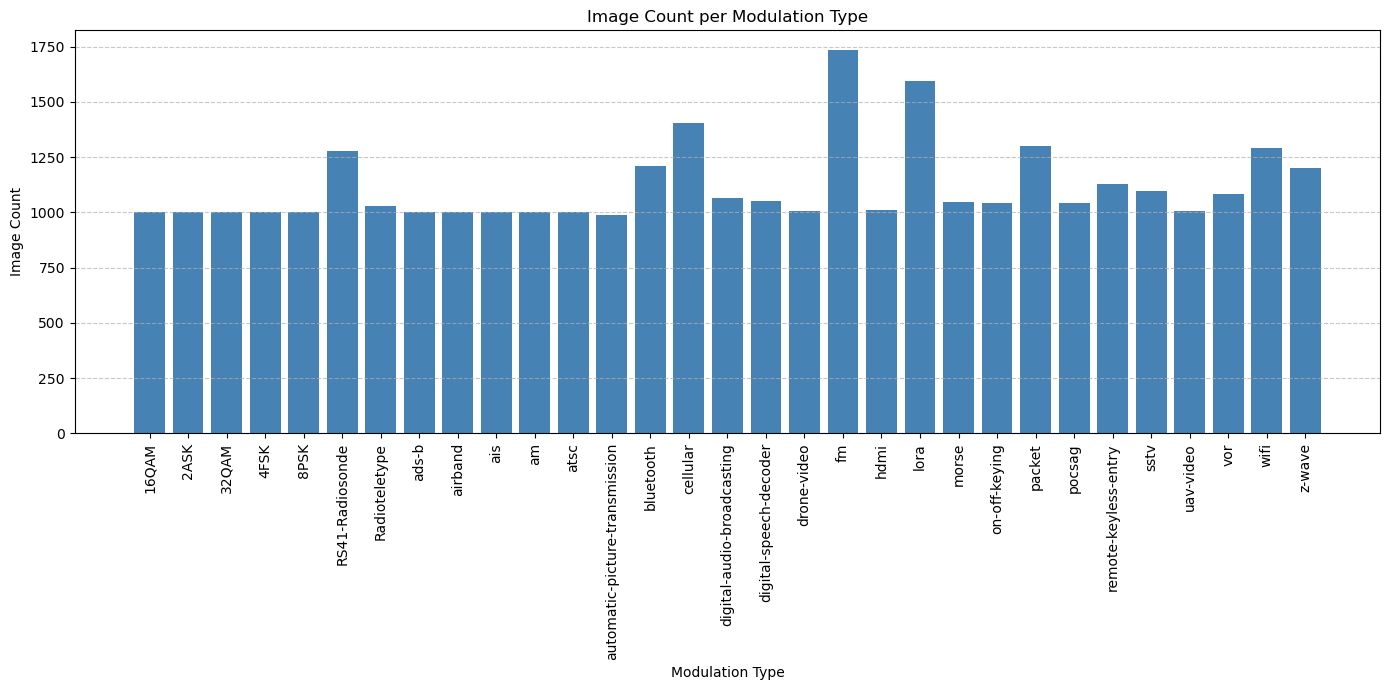

In [17]:
# Group by 'Modulation Type' and count image files
modulation_counts = df_deduped.groupby('Modulation Type')['Image File'].count()

# Define mapping from modulation type number to name
modulation_name_map = {
    1: "16QAM", 2: "2ASK", 3: "32QAM", 4: "4FSK", 5: "8PSK", 6: "RS41-Radiosonde",
    7: "Radioteletype", 8: "ads-b", 9: "airband", 10: "ais", 11: "am", 12: "atsc",
    13: "automatic-picture-transmission", 14: "bluetooth", 15: "cellular",
    16: "digital-audio-broadcasting", 17: "digital-speech-decoder", 18: "drone-video",
    19: "fm", 20: "hdmi", 21: "lora", 22: "morse", 23: "on-off-keying", 24: "packet",
    25: "pocsag", 26: "remote-keyless-entry", 27: "sstv", 28: "uav-video",
    29: "vor", 30: "wifi", 31: "z-wave"
}

# Convert to DataFrame
modulation_counts_df = modulation_counts.reset_index()
modulation_counts_df['Modulation Name'] = modulation_counts_df['Modulation Type'].map(modulation_name_map)
modulation_counts_df.columns = ['Modulation Type', 'Image Count', 'Modulation Name']
modulation_counts_df = modulation_counts_df[['Modulation Type', 'Modulation Name', 'Image Count']]

# Save to CSV
csv_output_path = os.path.join(balanced_dir, "modulation_image_counts.csv")
modulation_counts_df.to_csv(csv_output_path, index=False)
print(f"✅ CSV saved to: {csv_output_path}")

# Plot bar chart
plt.figure(figsize=(14, 7))
plt.bar(modulation_counts_df['Modulation Name'], modulation_counts_df['Image Count'], color='steelblue')
plt.xticks(rotation=90)
plt.title("Image Count per Modulation Type")
plt.xlabel("Modulation Type")
plt.ylabel("Image Count")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [18]:
# Show first 5 rows
print(modulation_counts_df.head(31))

    Modulation Type                 Modulation Name  Image Count
0                 1                           16QAM         1000
1                 2                            2ASK         1000
2                 3                           32QAM         1000
3                 4                            4FSK         1000
4                 5                            8PSK         1000
5                 6                 RS41-Radiosonde         1276
6                 7                   Radioteletype         1027
7                 8                           ads-b         1000
8                 9                         airband         1000
9                10                             ais         1000
10               11                              am         1000
11               12                            atsc         1000
12               13  automatic-picture-transmission          988
13               14                       bluetooth         1210
14               15      

In [19]:
# Add a column that marks whether the image was augmented or original
df_deduped['Augmented'] = df_deduped['Image File'].apply(lambda x: os.path.basename(x).startswith('aug_'))

# Optional: Count how many are augmented vs original
print(df_deduped['Augmented'].value_counts())

True     30667
False     3946
Name: Augmented, dtype: int64


In [20]:
# Show first 5 rows
print(df_deduped.head())

   Line Number  Modulation Type  \
0            1                9   
1            2               19   
2            3               15   
3            4               30   
4            5                9   

                                      Image File  Augmented  
0   airband\000b948821b3d6f1ff4f1e1c9ff0993f.png      False  
1        fm\001dfbacbf3bf79fa0342008144101b4.jpg      False  
2  cellular\001e0e34110b90d464f64be5b31c0f18.jpg      False  
3      wifi\006dc1c484f02d93ad64a2c77a3a60b7.jpg      False  
4   airband\0073085f5246828f3b2a515d5882d48d.png      False  


In [21]:
df_signals = df_deduped

In [22]:
correlation_matrix = df_signals.corr(numeric_only=True)
print(correlation_matrix)

                 Line Number  Modulation Type  Augmented
Line Number         1.000000        -0.017485   0.205625
Modulation Type    -0.017485         1.000000  -0.119805
Augmented           0.205625        -0.119805   1.000000


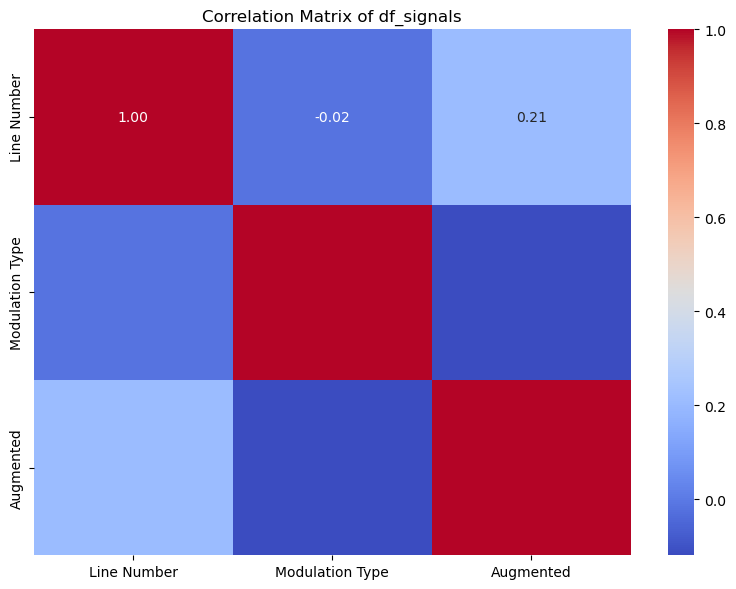

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_signals.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of df_signals")
plt.tight_layout()
plt.show()

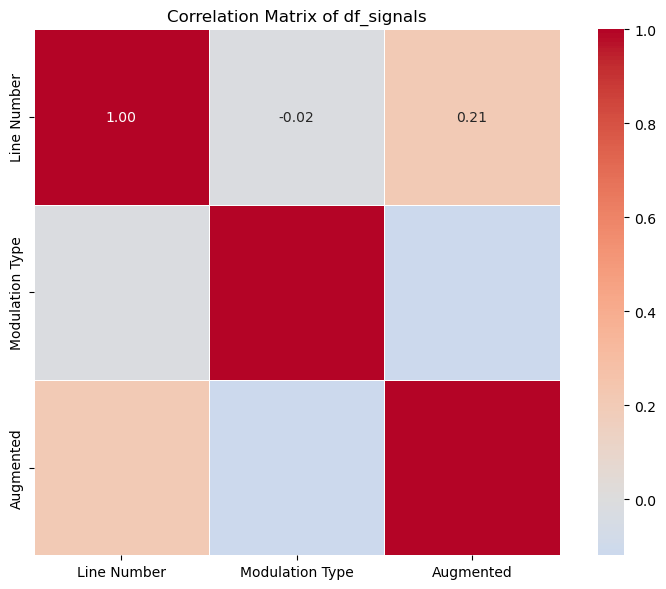

In [24]:
# Compute correlation matrix (only for numeric columns)
corr_matrix = df_signals.corr(numeric_only=True)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5, square=True)

# Add title and layout
plt.title("Correlation Matrix of df_signals")
plt.tight_layout()
plt.show()

In [25]:
# Create the summary table
summary = df_signals.groupby(['Modulation Type', 'Augmented'])['Image File'].count().unstack(fill_value=0)
summary.columns = ['Original Images', 'Augmented Images']
summary['Total Images'] = summary['Original Images'] + summary['Augmented Images']
summary = summary.reset_index()

# Add modulation names (if you have a mapping)
modulation_name_map = {
    1: "16QAM", 2: "2ASK", 3: "32QAM", 4: "4FSK", 5: "8PSK", 6: "RS41-Radiosonde",
    7: "Radioteletype", 8: "ads-b", 9: "airband", 10: "ais", 11: "am", 12: "atsc",
    13: "automatic-picture-transmission", 14: "bluetooth", 15: "cellular",
    16: "digital-audio-broadcasting", 17: "digital-speech-decoder", 18: "drone-video",
    19: "fm", 20: "hdmi", 21: "lora", 22: "morse", 23: "on-off-keying", 24: "packet",
    25: "pocsag", 26: "remote-keyless-entry", 27: "sstv", 28: "uav-video",
    29: "vor", 30: "wifi", 31: "z-wave"
}
summary['Modulation Name'] = summary['Modulation Type'].map(modulation_name_map)
summary = summary[['Modulation Type', 'Modulation Name', 'Original Images', 'Augmented Images', 'Total Images']]

# Display the table
print(summary)


    Modulation Type                 Modulation Name  Original Images  \
0                 1                           16QAM                8   
1                 2                            2ASK                5   
2                 3                           32QAM                8   
3                 4                            4FSK                5   
4                 5                            8PSK                8   
5                 6                 RS41-Radiosonde              276   
6                 7                   Radioteletype               27   
7                 8                           ads-b               32   
8                 9                         airband               66   
9                10                             ais              113   
10               11                              am                9   
11               12                            atsc               19   
12               13  automatic-picture-transmission             

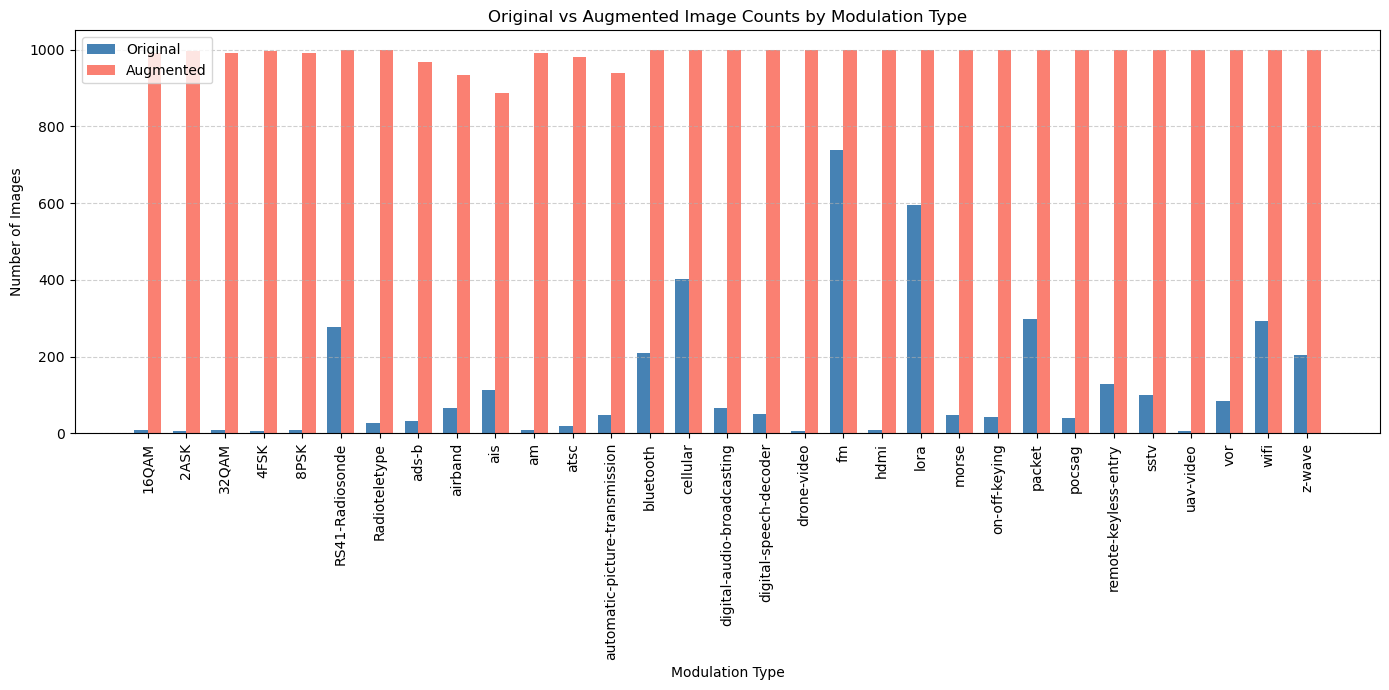

In [26]:
# Bar chart
plt.figure(figsize=(14, 7))
bar_width = 0.35
x = range(len(summary))

plt.bar(x, summary['Original Images'], width=bar_width, label='Original', color='steelblue')
plt.bar([i + bar_width for i in x], summary['Augmented Images'], width=bar_width, label='Augmented', color='salmon')

plt.xlabel('Modulation Type')
plt.ylabel('Number of Images')
plt.title('Original vs Augmented Image Counts by Modulation Type')
plt.xticks([i + bar_width / 2 for i in x], summary['Modulation Name'], rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [27]:
# Save table to CSV
summary.to_csv("modulation_image_summary.csv", index=False)

# Save chart as PNG
plt.savefig("modulation_image_bar_chart.png")

<Figure size 640x480 with 0 Axes>

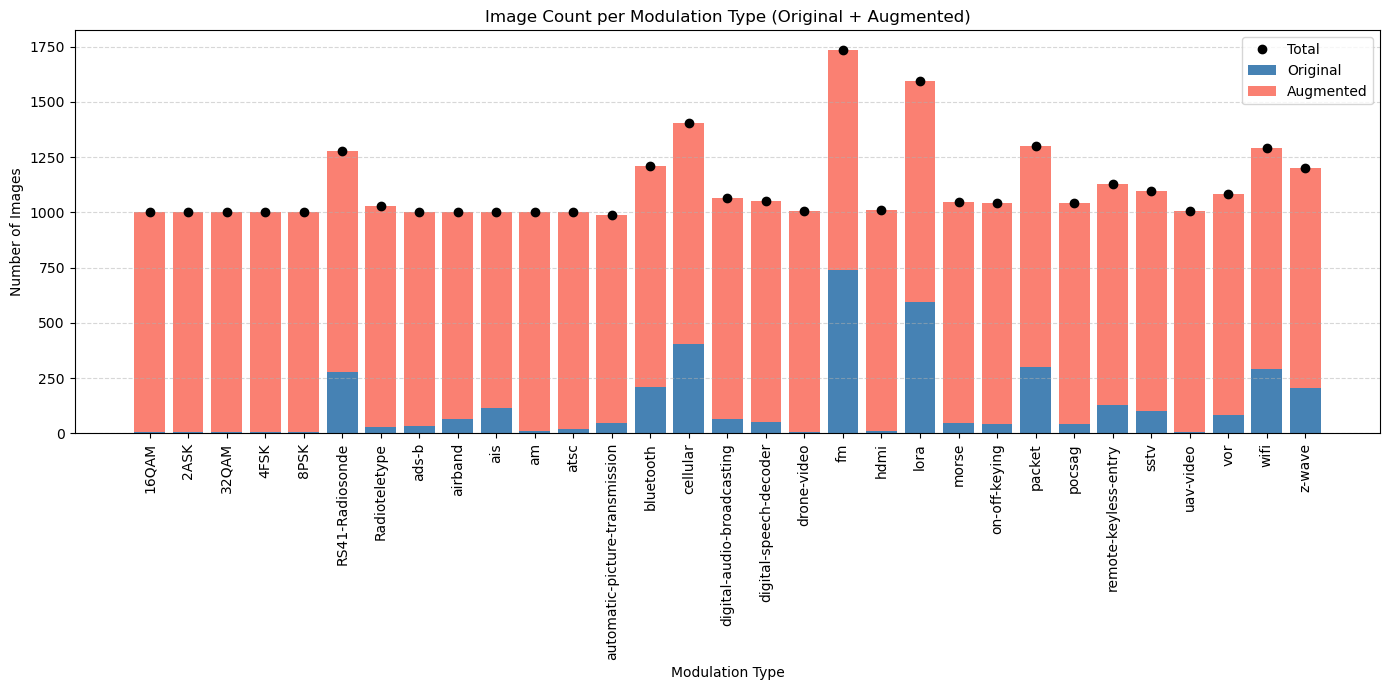

In [28]:
# Sort by modulation name (optional, for readability)
summary_sorted = summary.sort_values("Modulation Name")

# Set up the plot
plt.figure(figsize=(14, 7))

# Plot stacked bars: Original + Augmented
plt.bar(summary_sorted['Modulation Name'], summary_sorted['Original Images'], 
        label='Original', color='steelblue')
plt.bar(summary_sorted['Modulation Name'], summary_sorted['Augmented Images'], 
        bottom=summary_sorted['Original Images'], label='Augmented', color='salmon')

# Plot Total as black dots (optional)
plt.plot(summary_sorted['Modulation Name'], summary_sorted['Total Images'], 
         marker='o', color='black', linestyle='None', label='Total')

# Customize the plot
plt.xlabel('Modulation Type')
plt.ylabel('Number of Images')
plt.title('Image Count per Modulation Type (Original + Augmented)')
plt.xticks(rotation=90)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [29]:
# Group by modulation type and augmentation status
summary_table = df_signals.groupby(['Modulation Type', 'Augmented'])['Image File'].count().unstack(fill_value=0)

# Rename columns for clarity
summary_table.columns = ['Original Images', 'Augmented Images']

# Add total column
summary_table['Total Images'] = summary_table['Original Images'] + summary_table['Augmented Images']

# Calculate Original_Percentage
summary_table['Original_Percentage'] = summary_table['Original Images'] / summary_table['Total Images'] * 100

# Reset index to make 'Modulation Type' a column
summary_table = summary_table.reset_index()

# Add modulation name mapping
modulation_name_map = {
    1: "16QAM", 2: "2ASK", 3: "32QAM", 4: "4FSK", 5: "8PSK", 6: "RS41-Radiosonde",
    7: "Radioteletype", 8: "ads-b", 9: "airband", 10: "ais", 11: "am", 12: "atsc",
    13: "automatic-picture-transmission", 14: "bluetooth", 15: "cellular",
    16: "digital-audio-broadcasting", 17: "digital-speech-decoder", 18: "drone-video",
    19: "fm", 20: "hdmi", 21: "lora", 22: "morse", 23: "on-off-keying", 24: "packet",
    25: "pocsag", 26: "remote-keyless-entry", 27: "sstv", 28: "uav-video",
    29: "vor", 30: "wifi", 31: "z-wave"
}
summary_table['Modulation Name'] = summary_table['Modulation Type'].map(modulation_name_map)

# Rearrange columns
summary_table = summary_table[['Modulation Type', 'Modulation Name', 
                               'Original Images', 'Augmented Images', 
                               'Total Images', 'Original_Percentage']]

# Display the table
print(summary_table)

    Modulation Type                 Modulation Name  Original Images  \
0                 1                           16QAM                8   
1                 2                            2ASK                5   
2                 3                           32QAM                8   
3                 4                            4FSK                5   
4                 5                            8PSK                8   
5                 6                 RS41-Radiosonde              276   
6                 7                   Radioteletype               27   
7                 8                           ads-b               32   
8                 9                         airband               66   
9                10                             ais              113   
10               11                              am                9   
11               12                            atsc               19   
12               13  automatic-picture-transmission             

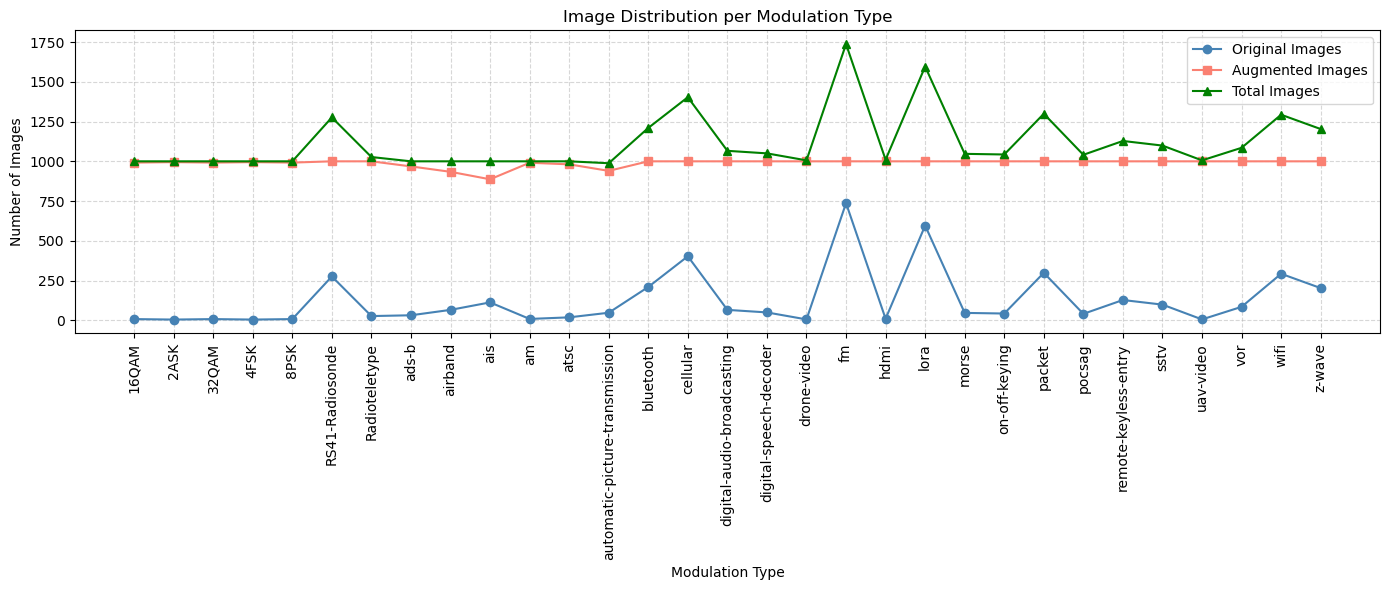

In [30]:
# Sort for cleaner x-axis display
summary_sorted = summary_table.sort_values("Modulation Name")

plt.figure(figsize=(14, 6))
plt.plot(summary_sorted['Modulation Name'], summary_sorted['Original Images'], 
         marker='o', label='Original Images', color='steelblue')
plt.plot(summary_sorted['Modulation Name'], summary_sorted['Augmented Images'], 
         marker='s', label='Augmented Images', color='salmon')
plt.plot(summary_sorted['Modulation Name'], summary_sorted['Total Images'], 
         marker='^', label='Total Images', color='green')

plt.xticks(rotation=90)
plt.xlabel('Modulation Type')
plt.ylabel('Number of Images')
plt.title('Image Distribution per Modulation Type')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


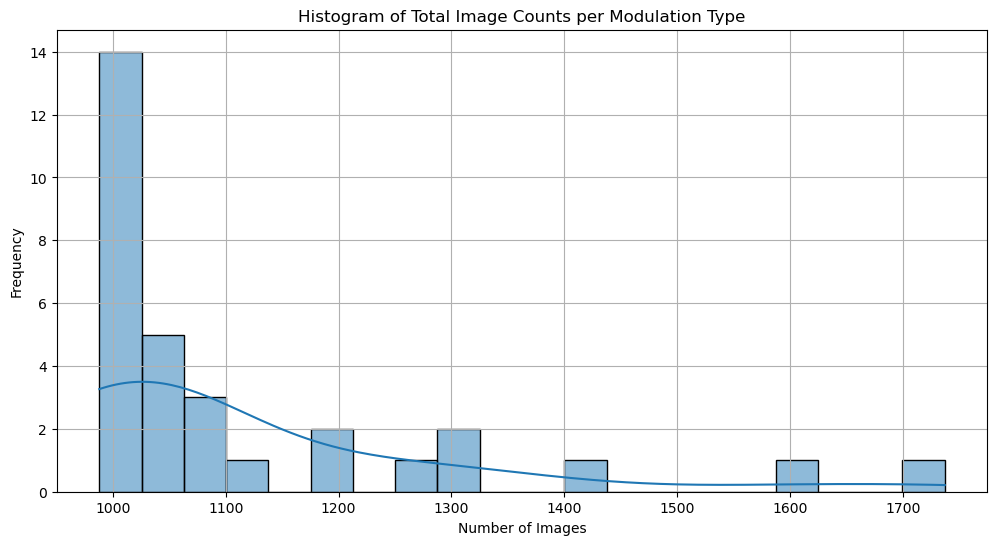

In [31]:
# Histogram of Image Counts per Modulation (Distribution)
plt.figure(figsize=(12,6))
sns.histplot(data=summary_table, x='Total Images', bins=20, kde=True)
plt.title('Histogram of Total Image Counts per Modulation Type')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

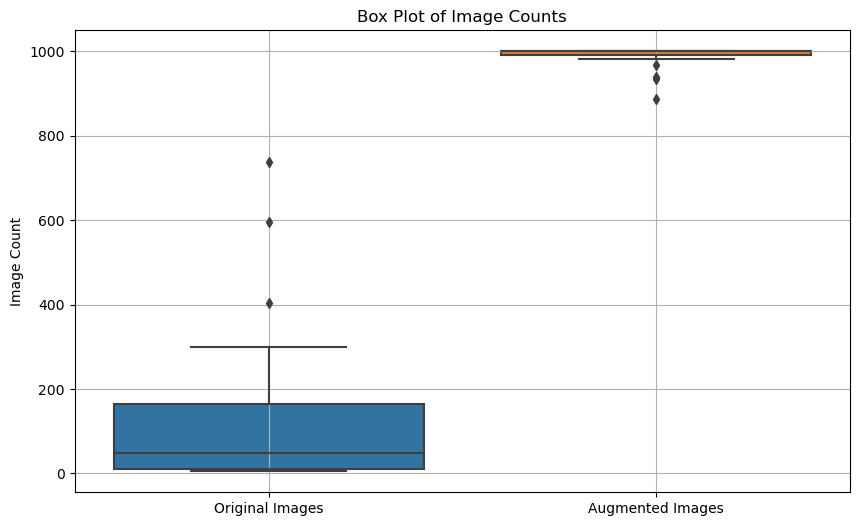

In [32]:
# Box Plot of Image Counts
plt.figure(figsize=(10,6))
sns.boxplot(data=summary_table[['Original Images', 'Augmented Images']])
plt.title('Box Plot of Image Counts')
plt.ylabel('Image Count')
plt.grid(True)
plt.show()

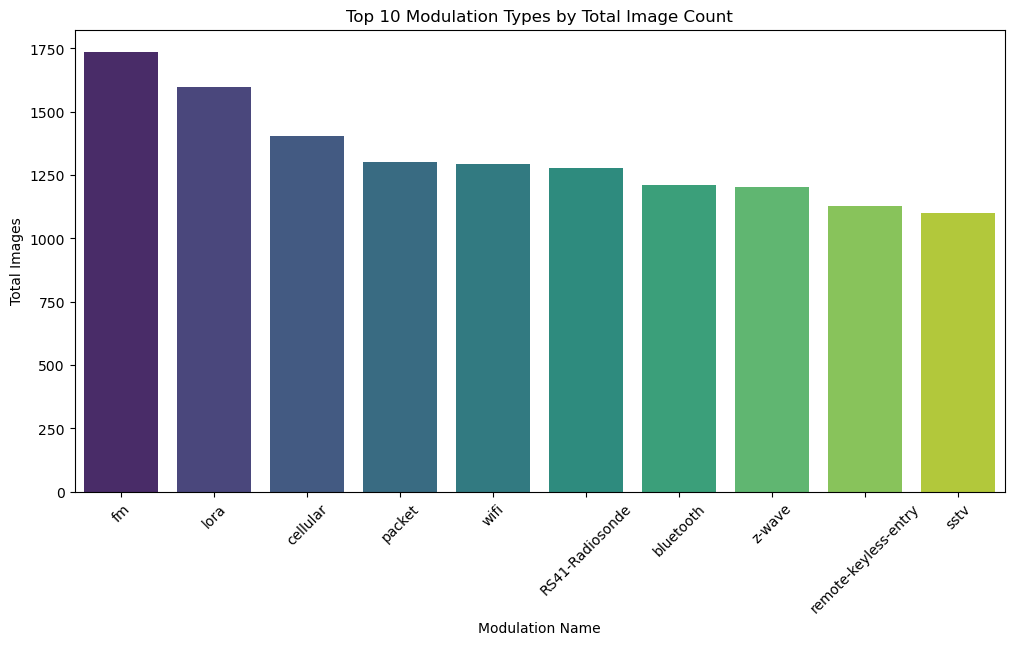

In [33]:
# Bar Chart of Top N Modulation Types by Image Count
top_n = summary_table.sort_values('Total Images', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x='Modulation Name', y='Total Images', data=top_n, palette='viridis')
plt.title('Top 10 Modulation Types by Total Image Count')
plt.ylabel('Total Images')
plt.xticks(rotation=45)
plt.show()

In [34]:
# Show first 5 rows
print(df_signals.head())

   Line Number  Modulation Type  \
0            1                9   
1            2               19   
2            3               15   
3            4               30   
4            5                9   

                                      Image File  Augmented  
0   airband\000b948821b3d6f1ff4f1e1c9ff0993f.png      False  
1        fm\001dfbacbf3bf79fa0342008144101b4.jpg      False  
2  cellular\001e0e34110b90d464f64be5b31c0f18.jpg      False  
3      wifi\006dc1c484f02d93ad64a2c77a3a60b7.jpg      False  
4   airband\0073085f5246828f3b2a515d5882d48d.png      False  


In [ ]:
# Build Neural Network

In [36]:
print(os.getcwd())

C:\Users\josep


In [37]:
df_signals.to_csv("df_signals.csv", index=False)

In [38]:
# === PARAMETERS ===
data_dir = r"C:\Users\josep\RF Signals Balanced"
img_size = (128, 128)
batch_size = 32
seed = 42

In [39]:
# === LOAD DATASETS ===
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

Found 44304 files belonging to 31 classes.
Using 35444 files for training.
Found 44304 files belonging to 31 classes.
Using 8860 files for validation.


In [40]:
# === GET CLASS NAMES ===
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes: {class_names}")

Classes: ['16QAM', '2ASK', '32QAM', '4FSK', '8PSK', 'RS41-Radiosonde', 'Radioteletype', 'ads-b', 'airband', 'ais', 'am', 'atsc', 'automatic-picture-transmission', 'bluetooth', 'cellular', 'digital-audio-broadcasting', 'digital-speech-decoder', 'drone-video', 'fm', 'hdmi', 'lora', 'morse', 'on-off-keying', 'packet', 'pocsag', 'remote-keyless-entry', 'sstv', 'uav-video', 'vor', 'wifi', 'z-wave']


In [41]:
# Get total number of batches
val_batches = tf.data.experimental.cardinality(val_ds)

# Take the first half as validation
new_val_ds = val_ds.take(val_batches // 2)

# Take the second half as test
test_ds = val_ds.skip(val_batches // 2)

In [42]:
# === PERFORMANCE ===
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [43]:
# === BUILD CNN MODEL ===
model = models.Sequential([
    layers.Input(shape=img_size + (3,)),
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

In [44]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       7

In [46]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
1108/1108 [==============================] - 764s 688ms/step - loss: 1.2199 - accuracy: 0.6528 - val_loss: 0.2835 - val_accuracy: 0.9204
Epoch 2/10
1108/1108 [==============================] - 731s 659ms/step - loss: 0.3908 - accuracy: 0.8800 - val_loss: 0.1562 - val_accuracy: 0.9560
Epoch 3/10
1108/1108 [==============================] - 801s 722ms/step - loss: 0.2629 - accuracy: 0.9177 - val_loss: 0.1138 - val_accuracy: 0.9641
Epoch 4/10
1108/1108 [==============================] - 663s 597ms/step - loss: 0.1989 - accuracy: 0.9387 - val_loss: 0.0776 - val_accuracy: 0.9778
Epoch 5/10
1108/1108 [==============================] - 765s 690ms/step - loss: 0.1647 - accuracy: 0.9480 - val_loss: 0.0774 - val_accuracy: 0.9772
Epoch 6/10
1108/1108 [==============================] - 690s 622ms/step - loss: 0.1374 - accuracy: 0.9555 - val_loss: 0.0605 - val_accuracy: 0.9825
Epoch 7/10
1108/1108 [==============================] - 873s 788ms/step - loss: 0.1266 - accuracy: 0.9582 - val_

In [47]:
# === EVALUATE ===
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")

139/139 [==============================] - 50s 230ms/step - loss: 0.0607 - accuracy: 0.9860

Test Accuracy: 0.9860


In [48]:
# === Generate predictions on test set ===
y_true = []
y_pred = []

In [49]:
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 [==============================] - 0s 231ms/step


In [50]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [51]:
# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
class_labels = class_names  # from earlier in your script

In [52]:
# Normalize by row (i.e., true class counts)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

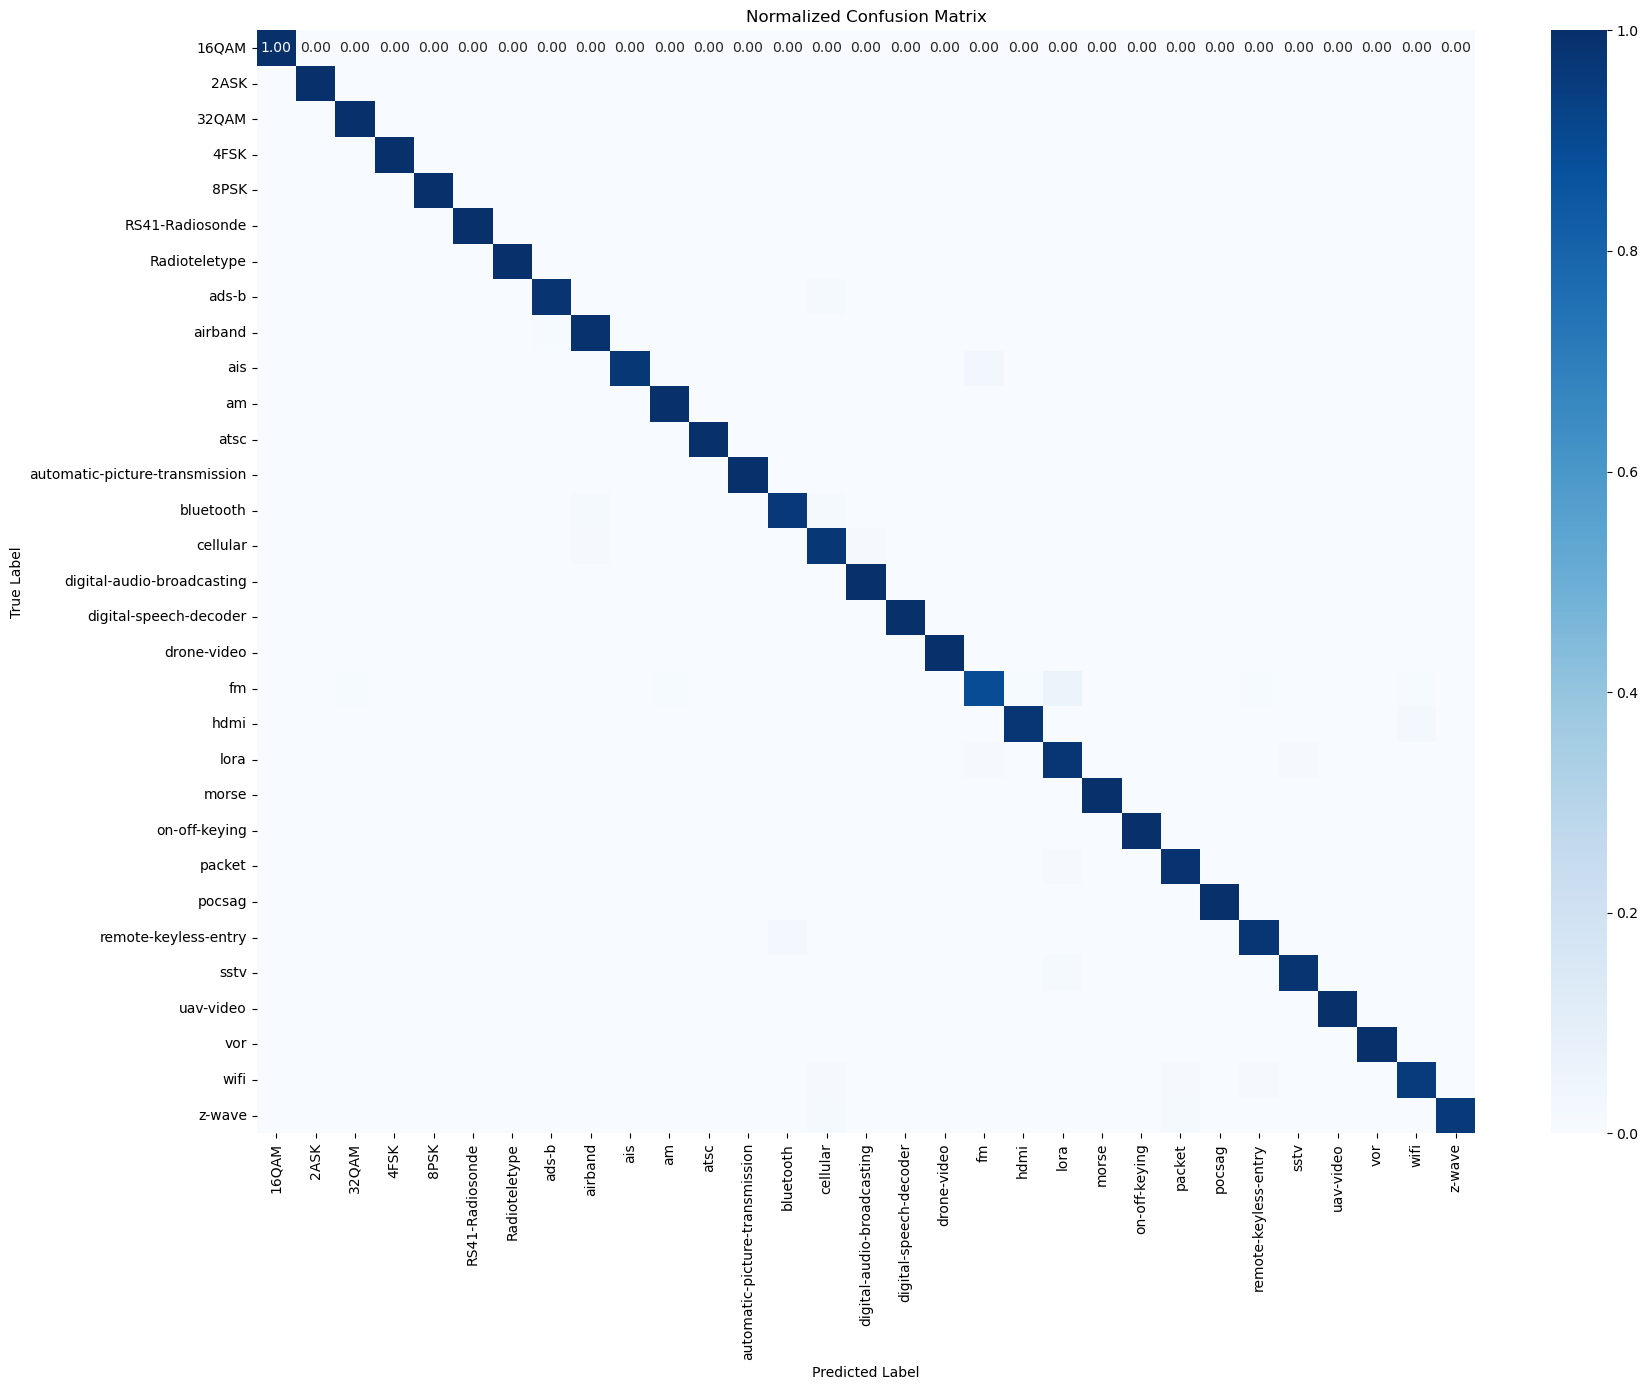

In [86]:
# === Plot Confusion Matrix ===
plt.figure(figsize=(18, 14))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

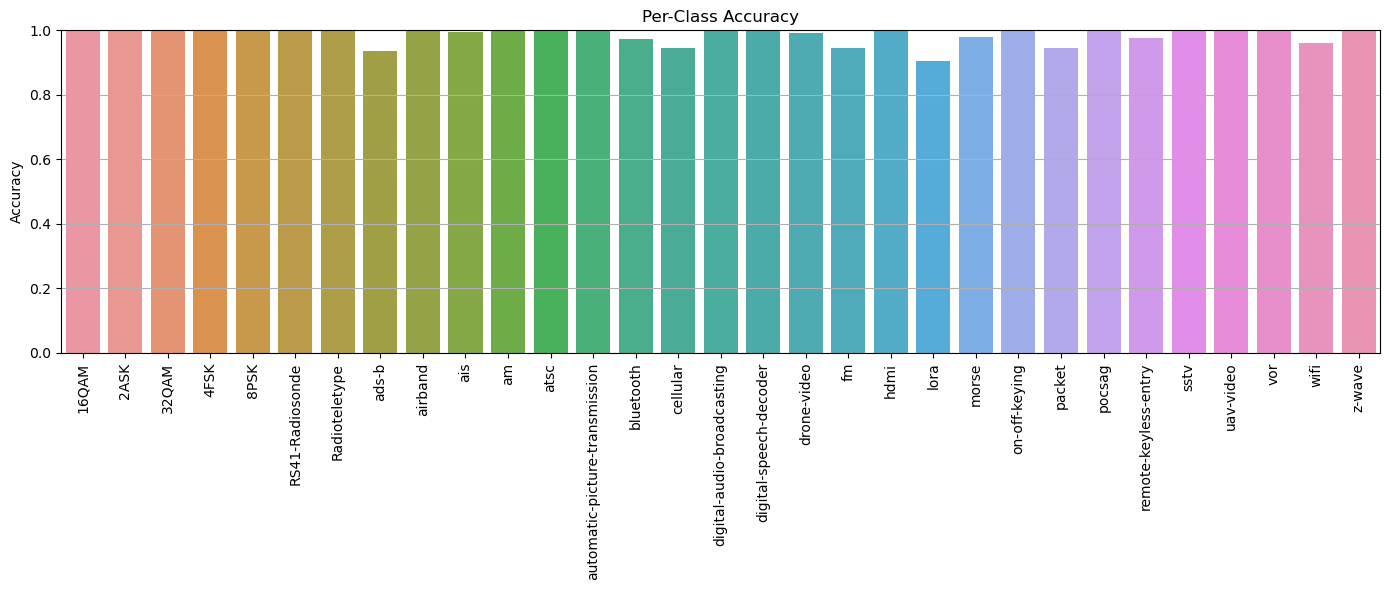

In [53]:
# === Per-Class Accuracy ===
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(14, 6))
sns.barplot(x=class_labels, y=per_class_accuracy)
plt.title('Per-Class Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [88]:
# === Display classification report ===
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
                                precision    recall  f1-score   support

                         16QAM       1.00      1.00      1.00        99
                          2ASK       1.00      1.00      1.00       103
                         32QAM       0.99      1.00      1.00       115
                          4FSK       1.00      1.00      1.00       101
                          8PSK       1.00      1.00      1.00        98
               RS41-Radiosonde       1.00      1.00      1.00        61
                 Radioteletype       1.00      1.00      1.00        45
                         ads-b       0.98      0.98      0.98        58
                       airband       0.98      0.99      0.99       109
                           ais       1.00      0.97      0.99       106
                            am       0.99      1.00      1.00       105
                          atsc       1.00      1.00      1.00       111
automatic-picture-transmission       1.0

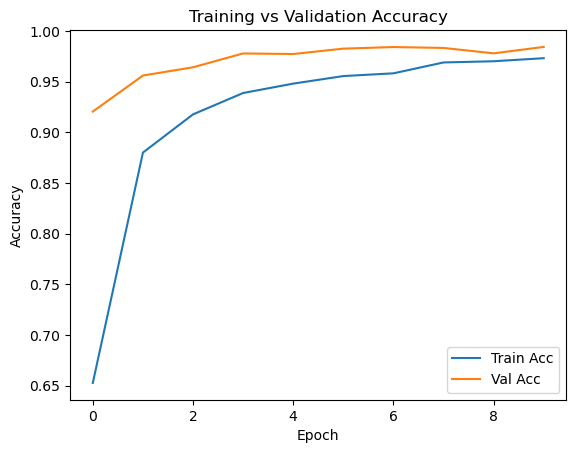

In [54]:
# === PLOT ACCURACY ===
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [ ]:
# Optimize CNN Model

In [ ]:
# Added BatchNormalization to normalizes activations between layers and help with faster convergence
# GlobalAveragePooling2D greatly reduces parameters compared to flattening and also improves generalization
# H_normalization is recommended for ReLU activation

In [56]:
model = models.Sequential([
    layers.Input(shape=img_size + (3,)),
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

In [57]:
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)      

In [59]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
1108/1108 [==============================] - 1069s 963ms/step - loss: 1.5192 - accuracy: 0.5530 - val_loss: 0.9915 - val_accuracy: 0.6798
Epoch 2/10
1108/1108 [==============================] - 1072s 965ms/step - loss: 0.5747 - accuracy: 0.8271 - val_loss: 0.3405 - val_accuracy: 0.8998
Epoch 3/10
1108/1108 [==============================] - 1068s 963ms/step - loss: 0.3494 - accuracy: 0.8956 - val_loss: 0.2745 - val_accuracy: 0.9113
Epoch 4/10
1108/1108 [==============================] - 1123s 1s/step - loss: 0.2581 - accuracy: 0.9229 - val_loss: 0.2410 - val_accuracy: 0.9236
Epoch 5/10
1108/1108 [==============================] - 1061s 957ms/step - loss: 0.2024 - accuracy: 0.9387 - val_loss: 0.1665 - val_accuracy: 0.9485
Epoch 6/10
1108/1108 [==============================] - 1024s 923ms/step - loss: 0.1649 - accuracy: 0.9487 - val_loss: 0.1169 - val_accuracy: 0.9611
Epoch 7/10
1108/1108 [==============================] - 1099s 990ms/step - loss: 0.1395 - accuracy: 0.9564 - 

In [60]:
# === EVALUATE ===
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")

139/139 [==============================] - 44s 226ms/step - loss: 0.1007 - accuracy: 0.9660

Test Accuracy: 0.9660


In [61]:
# === Generate predictions on test set ===
y_true = []
y_pred = []

In [62]:
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 [==============================] - 0s 278ms/step


In [63]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [64]:
# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
class_labels = class_names  # from earlier in your script

In [65]:
# Normalize by row (i.e., true class counts)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

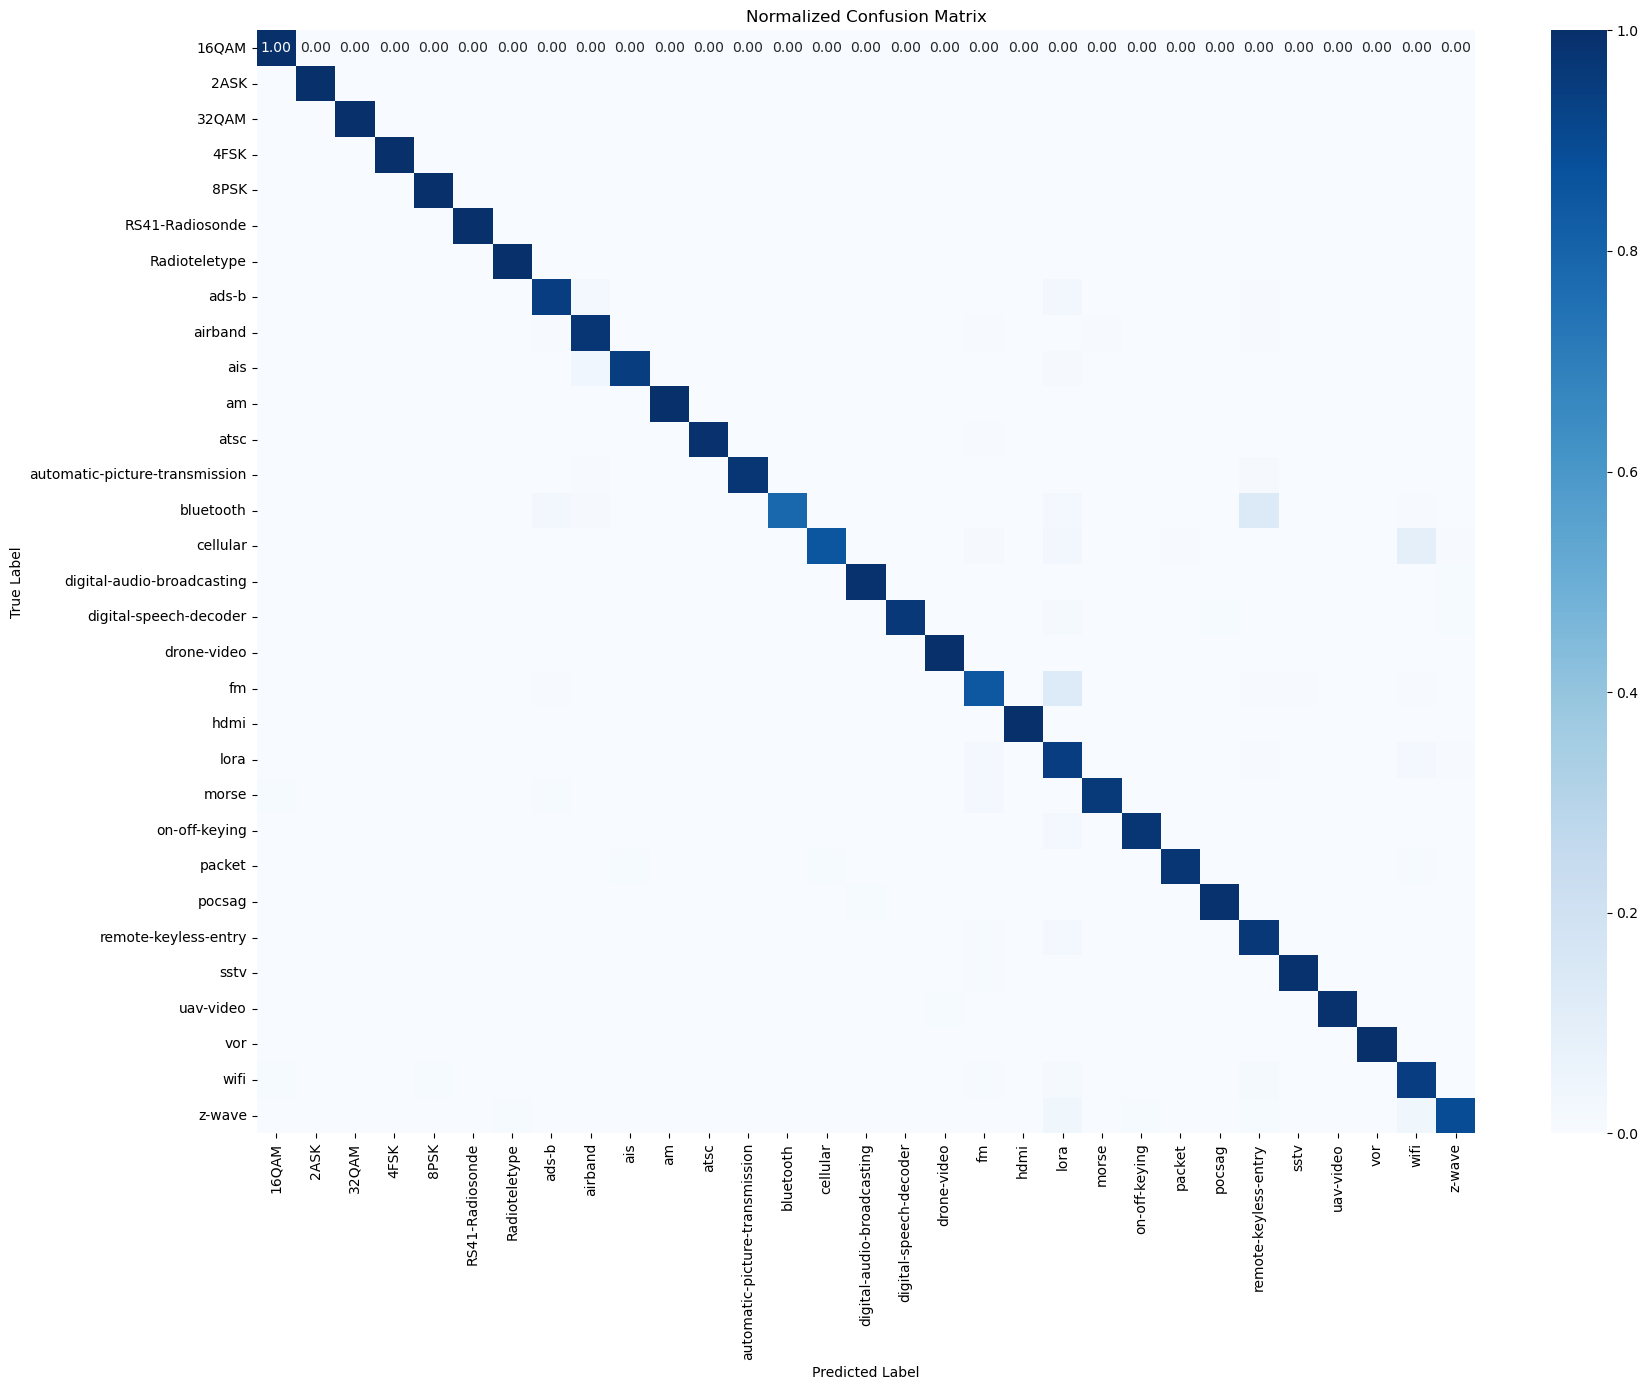

In [66]:
# === Plot Confusion Matrix ===
plt.figure(figsize=(18, 14))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

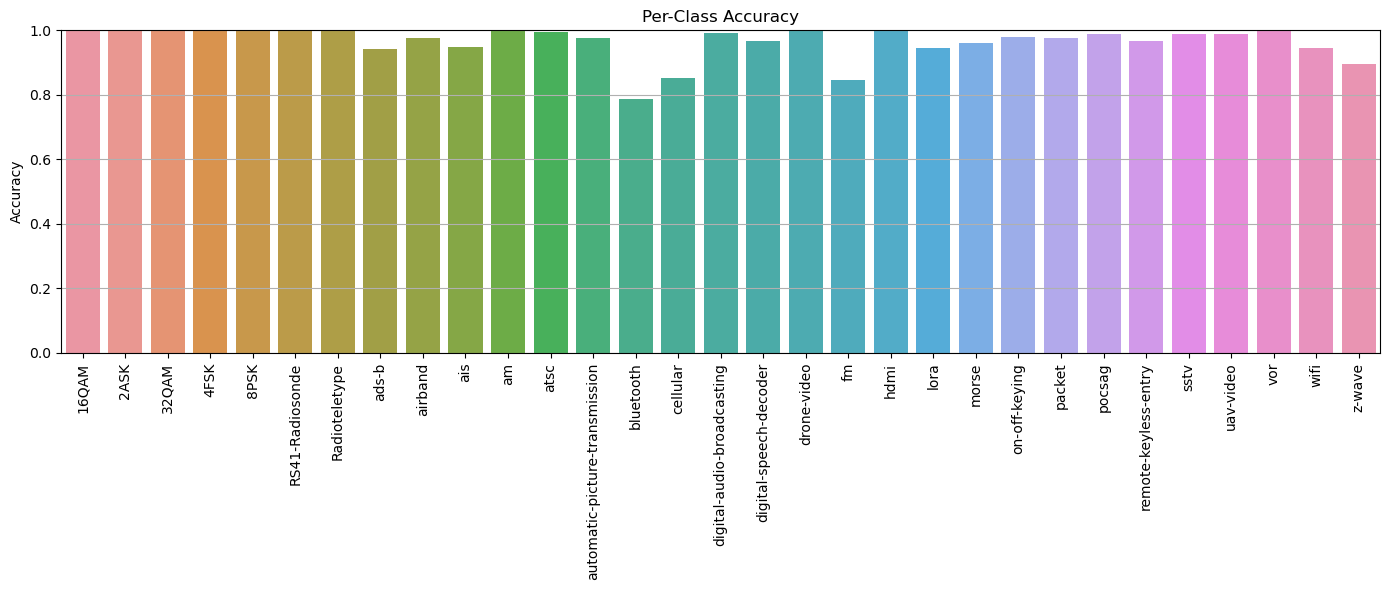

In [67]:
# === Per-Class Accuracy ===
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(14, 6))
sns.barplot(x=class_labels, y=per_class_accuracy)
plt.title('Per-Class Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [68]:
# === Display classification report ===
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
                                precision    recall  f1-score   support

                         16QAM       0.99      1.00      1.00       208
                          2ASK       1.00      1.00      1.00       194
                         32QAM       1.00      1.00      1.00       201
                          4FSK       1.00      1.00      1.00       201
                          8PSK       0.99      1.00      1.00       193
               RS41-Radiosonde       1.00      1.00      1.00       153
                 Radioteletype       0.99      1.00      1.00       114
                         ads-b       0.94      0.94      0.94       141
                       airband       0.93      0.98      0.95       177
                           ais       0.99      0.95      0.97       195
                            am       1.00      1.00      1.00       211
                          atsc       1.00      0.99      1.00       198
automatic-picture-transmission       1.0

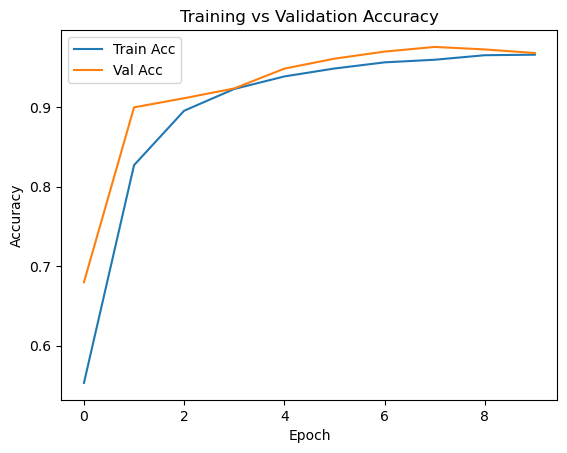

In [69]:
# === PLOT ACCURACY ===
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

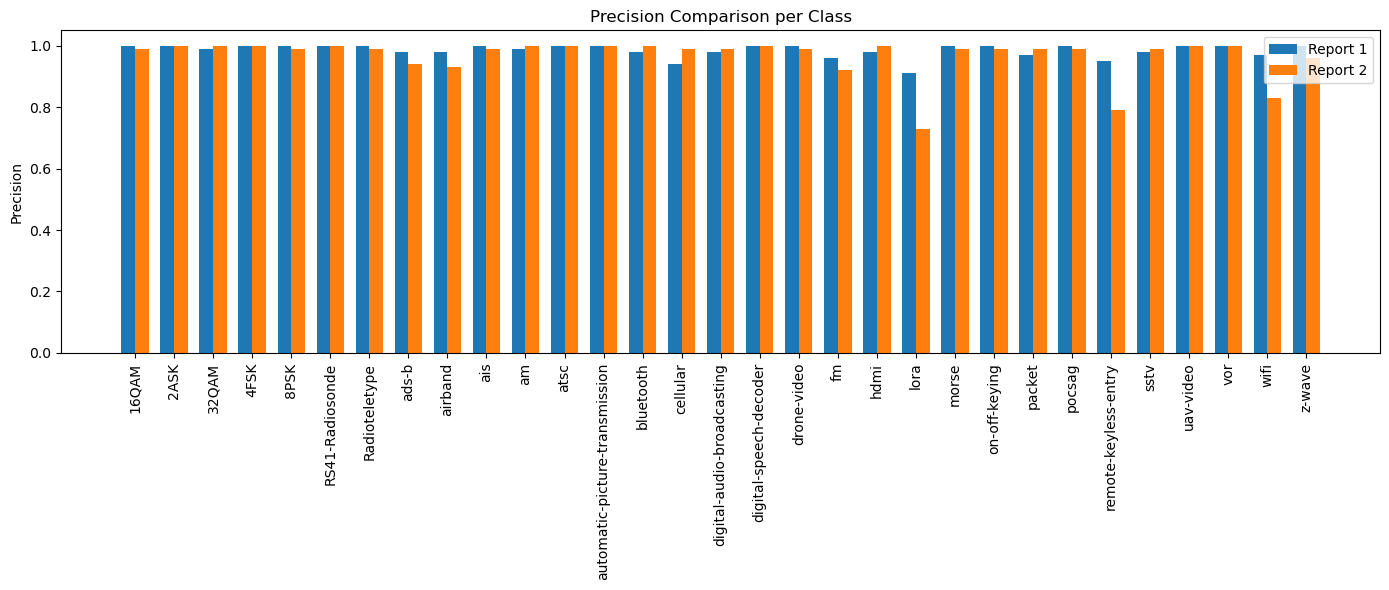

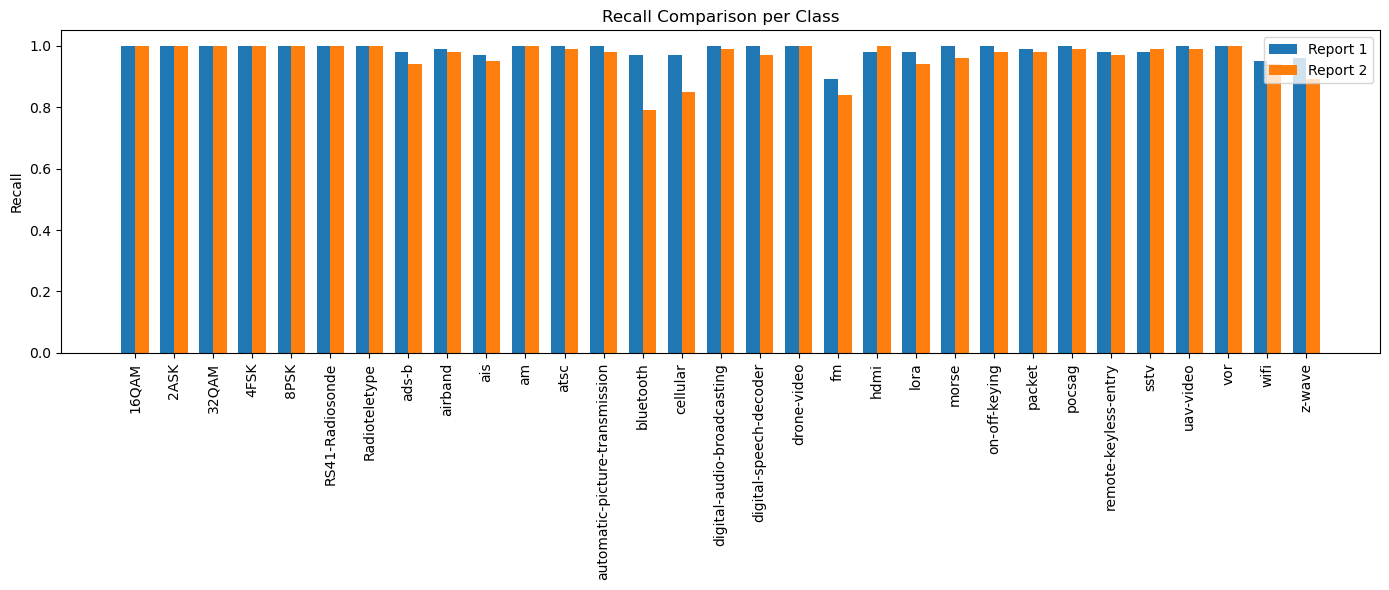

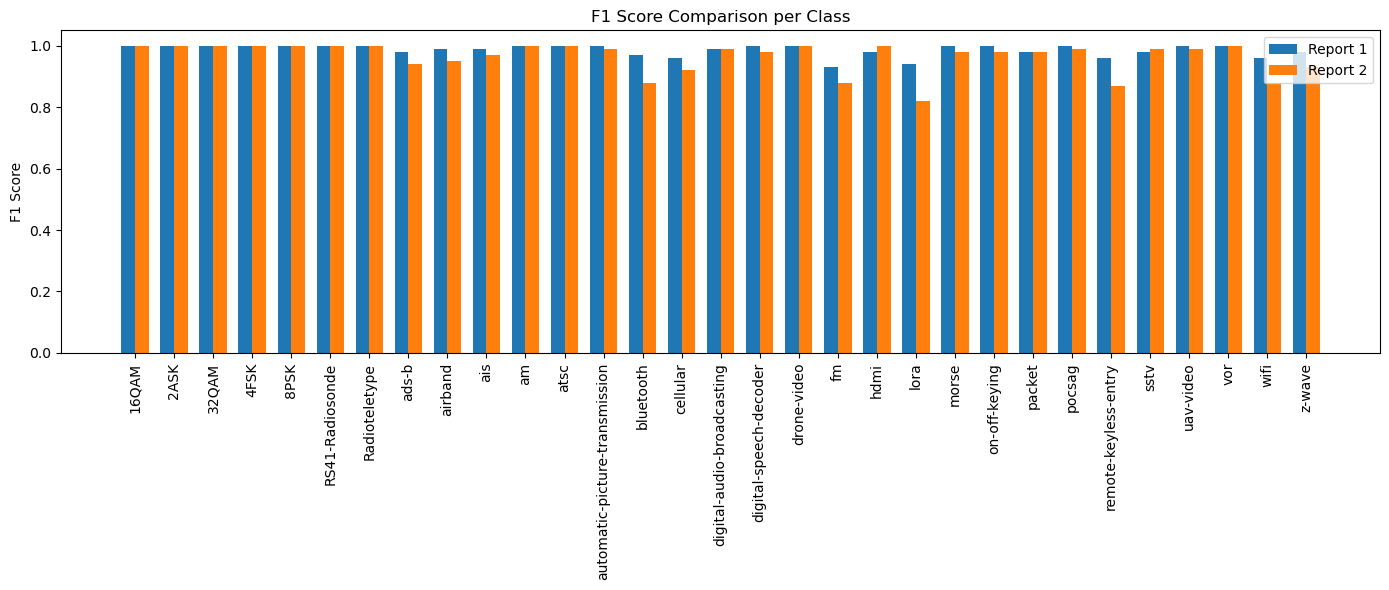

In [70]:
# Classification Report 1 data
report1 = {
    'class': ["16QAM","2ASK","32QAM","4FSK","8PSK","RS41-Radiosonde","Radioteletype","ads-b","airband","ais","am",
              "atsc","automatic-picture-transmission","bluetooth","cellular","digital-audio-broadcasting",
              "digital-speech-decoder","drone-video","fm","hdmi","lora","morse","on-off-keying","packet","pocsag",
              "remote-keyless-entry","sstv","uav-video","vor","wifi","z-wave"],
    'precision': [1.00,1.00,0.99,1.00,1.00,1.00,1.00,0.98,0.98,1.00,0.99,1.00,1.00,0.98,0.94,0.98,1.00,1.00,0.96,
                  0.98,0.91,1.00,1.00,0.97,1.00,0.95,0.98,1.00,1.00,0.97,1.00],
    'recall':    [1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.98,0.99,0.97,1.00,1.00,1.00,0.97,0.97,1.00,1.00,1.00,0.89,
                  0.98,0.98,1.00,1.00,0.99,1.00,0.98,0.98,1.00,1.00,0.95,0.96],
    'f1_score':  [1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.98,0.99,0.99,1.00,1.00,1.00,0.97,0.96,0.99,1.00,1.00,0.93,
                  0.98,0.94,1.00,1.00,0.98,1.00,0.96,0.98,1.00,1.00,0.96,0.98]
}

# Classification Report 2 data
report2 = {
    'class': ["16QAM","2ASK","32QAM","4FSK","8PSK","RS41-Radiosonde","Radioteletype","ads-b","airband","ais","am",
              "atsc","automatic-picture-transmission","bluetooth","cellular","digital-audio-broadcasting",
              "digital-speech-decoder","drone-video","fm","hdmi","lora","morse","on-off-keying","packet","pocsag",
              "remote-keyless-entry","sstv","uav-video","vor","wifi","z-wave"],
    'precision': [0.99,1.00,1.00,1.00,0.99,1.00,0.99,0.94,0.93,0.99,1.00,1.00,1.00,1.00,0.99,0.99,1.00,0.99,0.92,
                  1.00,0.73,0.99,0.99,0.99,0.99,0.79,0.99,1.00,1.00,0.83,0.96],
    'recall':    [1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.94,0.98,0.95,1.00,0.99,0.98,0.79,0.85,0.99,0.97,1.00,0.84,
                  1.00,0.94,0.96,0.98,0.98,0.99,0.97,0.99,0.99,1.00,0.94,0.89],
    'f1_score':  [1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.94,0.95,0.97,1.00,1.00,0.99,0.88,0.92,0.99,0.98,1.00,0.88,
                  1.00,0.82,0.98,0.98,0.98,0.99,0.87,0.99,0.99,1.00,0.88,0.93]
}

# Convert to DataFrames
df1 = pd.DataFrame(report1)
df2 = pd.DataFrame(report2)

# Merge for comparison
df = df1.merge(df2, on='class', suffixes=('_report1', '_report2'))

# Function to plot comparison
def plot_metric(metric_name):
    x = np.arange(len(df['class']))
    width = 0.35
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(x - width/2, df[f"{metric_name}_report1"], width, label='Report 1')
    ax.bar(x + width/2, df[f"{metric_name}_report2"], width, label='Report 2')
    ax.set_ylabel(metric_name.replace("_", " ").title())
    ax.set_title(f'{metric_name.replace("_", " ").title()} Comparison per Class')
    ax.set_xticks(x)
    ax.set_xticklabels(df['class'], rotation=90)
    ax.set_ylim(0, 1.05)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot precision, recall, and f1-score
plot_metric('precision')
plot_metric('recall')
plot_metric('f1_score')

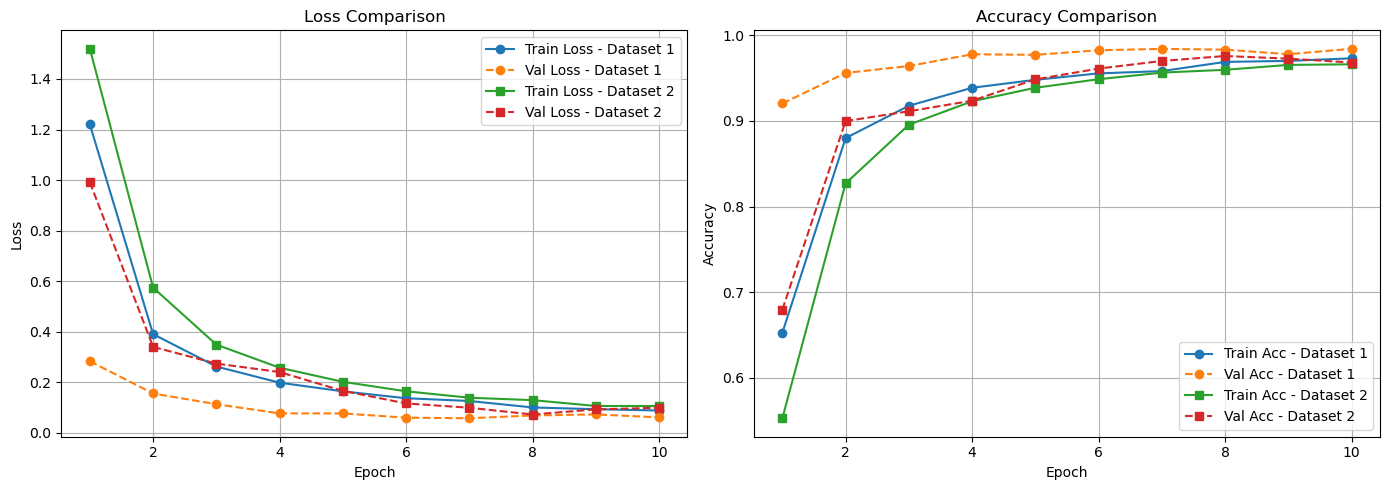

In [73]:
# Dataset 2 metrics
loss_2       = [1.5192, 0.5747, 0.3494, 0.2581, 0.2024, 0.1649, 0.1395, 0.1299, 0.1069, 0.1067]
acc_2        = [0.5530, 0.8271, 0.8956, 0.9229, 0.9387, 0.9487, 0.9564, 0.9597, 0.9654, 0.9661]
val_loss_2   = [0.9915, 0.3405, 0.2745, 0.2410, 0.1665, 0.1169, 0.0999, 0.0731, 0.0934, 0.0999]
val_acc_2    = [0.6798, 0.8998, 0.9113, 0.9236, 0.9485, 0.9611, 0.9700, 0.9758, 0.9727, 0.9682]

# Dataset 1 metrics
loss_1       = [1.2199, 0.3908, 0.2629, 0.1989, 0.1647, 0.1374, 0.1266, 0.1010, 0.0941, 0.0889]
acc_1        = [0.6528, 0.8800, 0.9177, 0.9387, 0.9480, 0.9555, 0.9582, 0.9689, 0.9701, 0.9731]
val_loss_1   = [0.2835, 0.1562, 0.1138, 0.0776, 0.0774, 0.0605, 0.0583, 0.0693, 0.0735, 0.0618]
val_acc_1    = [0.9204, 0.9560, 0.9641, 0.9778, 0.9772, 0.9825, 0.9841, 0.9832, 0.9779, 0.9842]

epochs = np.arange(1, 11)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axs[0].plot(epochs, loss_1, 'o-', label='Train Loss - Dataset 1')
axs[0].plot(epochs, val_loss_1, 'o--', label='Val Loss - Dataset 1')
axs[0].plot(epochs, loss_2, 's-', label='Train Loss - Dataset 2')
axs[0].plot(epochs, val_loss_2, 's--', label='Val Loss - Dataset 2')
axs[0].set_title('Loss Comparison')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot Accuracy
axs[1].plot(epochs, acc_1, 'o-', label='Train Acc - Dataset 1')
axs[1].plot(epochs, val_acc_1, 'o--', label='Val Acc - Dataset 1')
axs[1].plot(epochs, acc_2, 's-', label='Train Acc - Dataset 2')
axs[1].plot(epochs, val_acc_2, 's--', label='Val Acc - Dataset 2')
axs[1].set_title('Accuracy Comparison')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()